# Introduction

____

<center><i>This notebook is part two of two, focused on training and testing a classification model. Please visit <a href='EDA.ipynb'>EDA.ipynb</a> for part one, where source data is loaded and explored and features are engineered. </center></i>

____

<img src='./images/equity_equality.jpg'>

<center> Equality vs. equity <br> <i> <a href="interactioninstitute.org">Interaction Institute for Social Change</a> // Angus Maguire</i> </center>

**SUMMARY**

The purpose of this report is to analyze health inequities in the US by county and how those inequities influence the degree of impact of the COVID-19 pandemic.

____

**STAKEHOLDERS**

Federal, state, and local governments and epidemiologists can use this analysis to shape public health policy and pandemic response plans. The goal is to learn from COVID-19 to prevent the loss that occurred in 2020-2021 from happening again.

____

**DATA SOURCES**

- [CDC’s Social Vulnerability Index](https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html)

- [CDC's Vaccine Hesitancy](https://data.cdc.gov/Vaccinations/Vaccine-Hesitancy-for-COVID-19-County-and-local-es/q9mh-h2tw)

- [The University of Wisconsin Population Health Institute's County Health Rankings](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources) 

- [New York Times COVID Case and Death Counts](https://github.com/nytimes/covid-19-data)


____

**METHODS**

Classification model which predicts a given county’s degree of impact of the pandemic (high impact, average impact, low impact). Feature importance and coefficients will be analyzed to recommend what features put communities at greater risk in order to design policies to address the underlying issues.

____

**LOAD PACKAGES**

In [1]:
# style notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
#import standard packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

#import viz packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

#import stats packages
import sklearn
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, \
                            accuracy_score, roc_curve, auc, f1_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

#set random seed
rs=610
np.random.seed(rs)

# Data Load & Preprocessing

Data has been merged and partially preprocessed for modeling in the [EDA notebook.]('EDA.ipynb') We'll load in the merged dataframe and perform the following steps to ready the data for modeling:

- Split the state-level data into a training set and a testing set
- Drop any non-encoded, non-continuous features
- Standard scale continuous features
- Address class imbalance in the training sample

## Load Data

In [3]:
df = pd.read_csv('./data/merged_state_level_dataset.csv', index_col='State')
df

,cases,deaths,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Population Hesitant or Strongly Hesitant Towards COVID-19 Vaccine,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Income inequality raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value,cases per 100k,deaths per 100k,Percent of cases resulting in death,impact_points,impact_category,impact_category_code,state_abbr
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HAWAII,36680,515.0,0.3260,0.0960,0.0047,0.2893,0.0134,0.1314,0.2623,0.0912,6422,1422029,539053,456782,221.42,35526.00,10.82,3.72,9.02,17.58,18.54,0.18,0.15,0.95,0.61,0.41,4.34,6185.0450,0.1613,3.6530,3.8644,0.1637,0.2460,0.1898,0.2339,2082.5000,0.4125,82.0065,1230.7983,7.8500,0.1085,0.6204,0.8317,4.4691,6.9750,0.0000,0.1657,2579,36,1.404035,3873.7323,0-Low,0.0,HI
VERMONT,24433,258.0,0.1971,0.0181,0.0035,0.0099,0.0094,0.0004,0.9389,0.0620,9217,624977,333013,259589,67.80,31966.00,11.27,4.24,8.21,19.46,19.01,0.20,0.31,0.18,0.46,0.20,4.31,6774.5357,0.1393,3.8469,4.5565,0.1681,0.2828,0.2036,0.2158,3447.4286,0.4671,79.4099,1539.0478,8.3429,0.1086,0.7435,0.8000,4.3180,5.4214,0.5000,0.7537,3909,41,1.055949,4344.1739,0-Low,0.0,VT
ALASKA,70774,360.0,0.7445,0.0531,0.3246,0.0539,0.0133,0.0053,0.4787,0.3743,570982,738516,315386,253462,1.29,32531.21,13.32,9.41,9.79,11.80,24.54,0.39,0.37,0.69,0.82,0.56,19.93,9636.3187,0.1984,4.7529,4.5961,0.2416,0.3309,0.2248,0.1910,3320.8333,0.2907,78.0253,1297.5531,6.1400,0.1523,0.6499,0.7669,4.3408,8.1250,0.6000,0.6592,9583,48,0.508661,4996.5807,0-Low,0.0,AK
MAINE,69118,860.0,0.3119,0.0155,0.0081,0.0079,0.0084,0.0003,0.9400,0.1743,30844,1332813,739077,556955,43.21,28983.25,13.78,5.22,8.36,21.12,18.76,0.35,0.45,0.19,0.50,0.33,9.34,7381.4989,0.1720,4.2104,4.8363,0.2056,0.3087,0.2210,0.2138,3482.1250,0.4331,78.3590,1185.7795,7.8375,0.1352,0.7466,0.7950,4.4482,6.4125,0.5625,0.7419,5185,64,1.244249,6849.5906,0-Low,0.0,ME
OREGON,209561,2812.0,0.5294,0.1210,0.0165,0.0168,0.0073,0.0033,0.8030,0.1977,95987,4081943,1750539,1591835,42.53,27690.11,15.25,6.82,11.11,21.07,20.75,0.51,0.56,0.58,0.70,0.60,7.80,6915.3168,0.1946,4.8098,5.0737,0.1941,0.3224,0.2132,0.2058,2634.1176,0.3968,79.1716,1559.4675,7.4059,0.1308,0.6591,0.8149,4.3304,6.5618,0.6176,0.4110,5133,68,1.341853,7343.9600,0-Low,0.0,OR
UTAH,417330,2385.0,0.5072,0.0921,0.0285,0.0081,0.0046,0.0033,0.8484,0.1894,82195,3045350,1066131,957619,37.05,25467.79,11.87,4.01,8.29,14.18,29.50,0.35,0.30,0.55,0.33,0.32,11.92,6925.1158,0.1629,4.0783,4.1899,0.1228,0.2785,0.1923,0.1164,2674.2222,0.4189,79.2940,2307.8994,7.2821,0.1267,0.7477,0.8348,3.8615,6.3571,0.6071,0.4651,13703,78,0.571490,8054.0112,0-Low,0.0,UT
WASHINGTON,455630,6011.0,0.4605,0.1445,0.0189,0.0275,0.0134,0.0032,0.7554,0.1346,66453,7294336,3064381,2800423,109.77,29278.85,14.24,6.07,11.25,19.66,21.67,0.44,0.48,0.66,0.57,0.52,7.88,6557.6389,0.1803,4.3815,4.4092,0.1584,0.3148,0.1942,0.1904,2685.4359,0.4023,79.9804,1828.8292,7.4026,0.1285,0.6842,0.8280,4.3645,6.6282,0.3846,

## Multicollinearity

In [77]:
def multicollinearity(data, min_correlation=0.75, figsize=(12,10), annot=True):
    '''
    Parameters:
    data - pd.DataFrame, primary dataset to read from
    min_correlation - float (0-1), the smallest correlation between two variables to be considered multicollinear (default=0.75)
    figsize - tuple, width and height of the resulting figure (default=(12,10))
    annot - bool, overlay figure with the correlation values for each feature combo (default=True)
    
    Returns:
    Dataframe of feature pairs with correlation >= min_correlation
    Heatmap of feature correlations
    '''
    import seaborn as sns
    
    df = data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df = df.set_index('pairs').drop(columns=['level_0', 'level_1'])
    df.columns = ['correlation']
    df.drop_duplicates(inplace=True)
    
    mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    cmap = sns.diverging_palette(240, 0, sep=60, s=75, as_cmap=True)
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(data.corr().abs(), center=0, linewidths=.3, mask=mask, annot=annot, 
                cmap=cmap, square=True)
    return df[df.correlation > min_correlation] 

,correlation
pairs,
"(cases, cases)",1.000000
"(impact_points, deaths per 100k)",0.999141
"(housing units count, households count)",0.998739
"(population, households count)",0.996978
"(population, housing units count)",0.993825
...,...
"(CVAC level of concern for vaccination rollout, svi socioeconomic ranking)",0.758834
"(poverty rate, Food environment index raw value)",0.758118
"(Life expectancy raw value, Food insecurity raw value)",0.757674


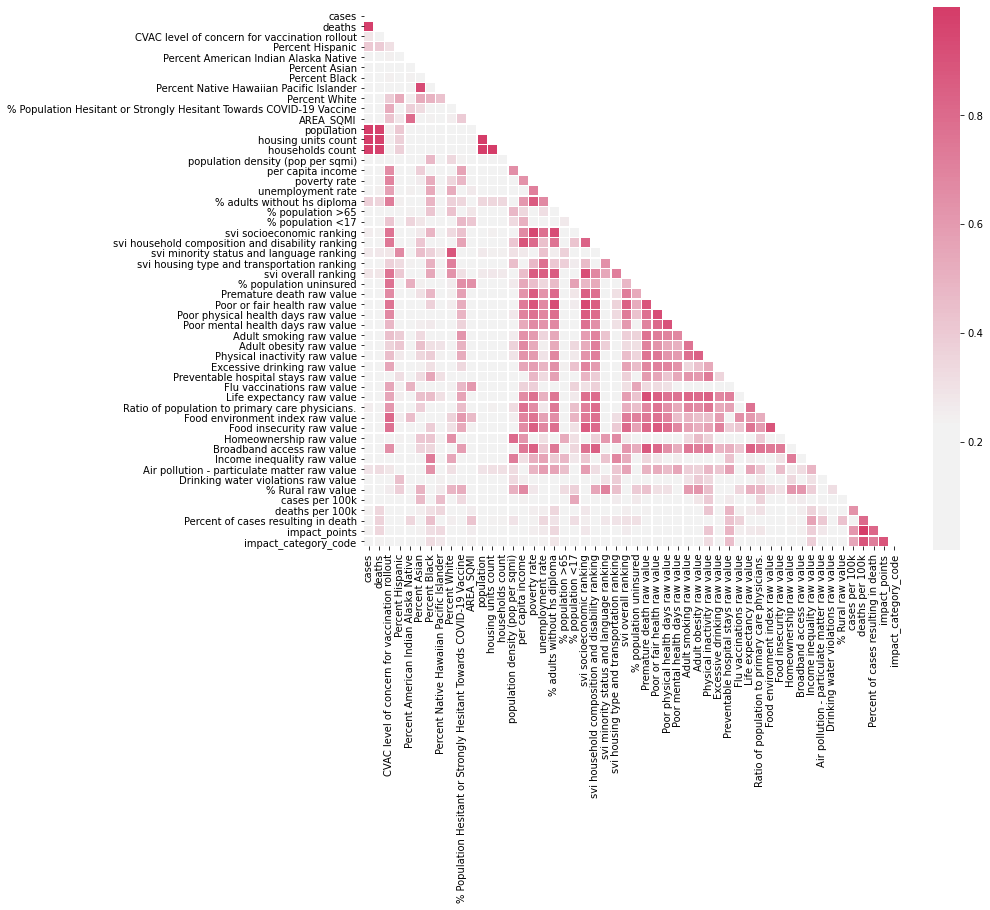

In [79]:
multicollinearity(df, annot=False)

# Multi-Class Classification Problem 

The engineered target feature - Pandemic Impact Category - has three possible values: 0-Low, 1-Average, or 2-High. This means we have what's called a multi-class classification problem.

There are two schools of solutions for multi-class classification problems that we will try:
1. **Multiclass regressors** - scikit learn's various classes with hyperparameters passed to support a target with multiple classes
1. **Meta-classifiers** - binarize the target, create a base estimator, then fit "n" number of classifiers one for each class. This approach considers each combination of labels as a binary prediction.

I'll evaluate models using the following metrics:

- **Overfitting** - the difference between the accuracy score on the training data and the accuracy score on the testing data. Lower numbers are better, as they indicate the model is not too overfit on the training data and is extensible to new observations.
- **Accuracy** - measure of how many predictions the model gets right. Higher numbers are desirable.
- **AUC** - an alternative measure of model accuracy. Higher numbers are desirable
- **F1 Score** - represents the harmonic mean of precision (how many predicted positives are true positives) and recall (how many actual positives were correctly predicted). Higher numbers are desirable.

Metrics for my multiclass models could be calculated as a **Macro-average** - which computes the metric independently for each class then takes the average - or the **Micro-average** - which aggregates the contributions of all classes, then calculates the metric. The micro-average is a way to take a weighted average, but because I know my classes are balanced, I can safely use the macro-average.


## Functions

In [52]:
def evaluate_multiclass_regressor(model, X_train, y_train, X_test, y_test, cmap='Blues',
                                  track=True, stats_df=None, name=None):
    #fit model
    model.fit(X_train, y_train)
    
    #generate class preditions
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)
    
    #calculate accuracy
    test_acc = accuracy_score(y_test, y_test_preds, normalize=True)
    train_acc = accuracy_score(y_train, y_train_preds, normalize=True)
    
    #check for overfitting
    overfit = train_acc - test_acc
    
    #calculate ROC AUC
    auc = sklearn.metrics.roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    
    #calculate F1 score
    f1 = sklearn.metrics.f1_score(y_test, y_test_preds, average='macro')
    
    print('----CLASSIFICATION REPORT----')
    print(classification_report(y_test, y_test_preds, target_names=['0-Low', '1-Average', '2-High']))
    
    plot_confusion_matrix(model, X_test_scaled, y_test, cmap='Blues', normalize='true',
                          display_labels=['0-Low', '1-Average', '2-High'])
    
    #instantiate df if not passed
    if stats_df is None:
        stats_df = pd.DataFrame(columns=['Model Name', 'Overfit Check', 'Accuracy', 'AUC', 'F1 Score'])

    #collect metrics in a dictionary    
    stats_dict = {}
    stats_dict['Model Name'] = name
    stats_dict['Overfit Check'] = overfit
    stats_dict['Accuracy'] = test_acc
    stats_dict['AUC'] = auc
    stats_dict['F1 Score'] = f1    
    
    #if set to track results of this model for aggregation, append dict to stats_df
    if track == True:
        stats_df = stats_df.append(pd.Series(stats_dict), ignore_index=True)
        return stats_df

## Preprocessing

____

**TRAIN-TEST SPLIT**

Before doing anything more with the data, need to create separate training and testing samples. This allows us to verify the performance of our models by predicting the targets of the test set, then comparing with the actual values.

Not all columns in the dataframe should be used as predictors since some of them were used to engineer the target feature. Case and death counts (both raw values and population-controlled) will be dropped, as well as the engineered percent of cases resulting in death. Impact points of course will also be removed.

In [5]:
# split the data into target (y) and predictors (X)
y = df['impact_category_code'].astype(int)
# drop columns I don't want to use as predictors
X = df.drop(columns=['impact_category_code', 
                     'cases', 'deaths', 'cases per 100k', 'deaths per 100k', 
                     'Percent of cases resulting in death', 'state_abbr', 
                     'impact_category', 'impact_points'])

In [6]:
#train-test split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
print(f'X_train: {len(X_train)}')
print(f'y_train: {len(y_train)}')
print(f'X_test: {len(X_test)}')
print(f'y_test: {len(y_test)}')

X_train: 40
y_train: 40
X_test: 11
y_test: 11


In [7]:
display(X_train.head())
display(y_train)
display(X_test.head())
display(y_test)

,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Population Hesitant or Strongly Hesitant Towards COVID-19 Vaccine,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Income inequality raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MICHIGAN,0.4002,0.0363,0.0135,0.0107,0.0382,0.0003,0.8775,0.1609,56602,9957488,4580939,3909509,175.92,26889.59,14.99,6.66,9.57,20.70,20.07,0.49,0.47,0.33,0.45,0.42,6.89,7606.3590,0.1895,4.6338,4.9356,0.2272,0.3408,0.2472,0.2111,3842.0000,0.4192,78.0957,2381.2893,7.5732,0.1366,0.7792,0.7753,4.1640,7.1855,0.0964,0.6164
NEBRASKA,0.2368,0.0696,0.0125,0.0056,0.0093,0.0003,0.8891,0.1403,76817,1904760,830749,754063,24.80,28545.91,11.00,2.66,8.56,20.92,23.05,0.21,0.41,0.35,0.22,0.20,8.32,6794.0460,0.1475,3.3861,3.7421,0.1754,0.3533,0.2689,0.2304,3587.8354,0.3713,79.2348,1885.4239,7.5937,0.1191,0.7302,0.7764,3.9799,6.0215,0.2405,0.7016
MINNESOTA,0.3309,0.0457,0.0191,0.0153,0.0177,0.0005,0.8821,0.1199,79625,5527358,2420473,2167801,69.42,30827.47,10.75,3.62,8.10,18.95,22.99,0.19,0.39,0.38,0.45,0.27,5.06,6207.2536,0.1434,3.5155,3.7648,0.1965,0.3300,0.2381,0.2315,5846.3448,0.4480,80.1733,2121.5603,8.4747,0.0860,0.7681,0.7911,4.0491,6.3069,0.2069,0.6134
MASSACHUSETTS,0.0329,0.0930,0.0022,0.0404,0.0578,0.0004,0.7753,0.0800,7801,6830193,2882739,2601914,875.53,40222.43,10.69,5.21,8.56,17.64,19.43,0.22,0.17,0.70,0.55,0.33,3.05,6001.0654,0.1424,3.6816,4.5740,0.1615,0.2579,0.2004,0.2395,4429.5714,0.5464,80.4496,1230.8058,8.7286,0.0848,0.6602,0.8543,5.0479,6.1786,0.3571,0.1675
LOUISIANA,0.7420,0.0367,0.0057,0.0084,0.3175,0.0002,0.6143,0.3067,43203,4663616,2045554,1736021,107.94,23582.08,22.00,7.56,18.38,15.53,23.58,0.76,0.67,0.63,0.72,0.79,11.53,10075.1504,0.2476,4.8599,5.2967,0.2534,0.3849,0.3035,0.1921,6456.4844,0.4009,75.5373,3537.0466,6.6781,0.1654,0.6967,0.6909,5.6471,8.7187,0.7812,0.5109


State
MICHIGAN                1
NEBRASKA                1
MINNESOTA               1
MASSACHUSETTS           2
LOUISIANA               2
ARIZONA                 2
NORTH DAKOTA            1
ALASKA                  0
NEW HAMPSHIRE           0
SOUTH CAROLINA          1
OREGON                  0
WISCONSIN               1
NEW MEXICO              1
FLORIDA                 1
DISTRICT OF COLUMBIA    1
NEW YORK                1
NEVADA                  1
RHODE ISLAND            2
VIRGINIA                1
TENNESSEE               1
HAWAII                  0
NEW JERSEY              2
GEORGIA                 1
WYOMING                 1
OHIO                    1
ILLINOIS                1
SOUTH DAKOTA            2
OKLAHOMA                1
TEXAS                   1
MONTANA                 1
ARKANSAS                1
COLORADO                1
MARYLAND                1
WEST VIRGINIA           1
KANSAS                  1
INDIANA                 1
MISSISSIPPI             2
NORTH CAROLINA          1
MAINE 

,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Population Hesitant or Strongly Hesitant Towards COVID-19 Vaccine,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Income inequality raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VERMONT,0.1971,0.0181,0.0035,0.0099,0.0094,0.0004,0.9389,0.0620,9217,624977,333013,259589,67.80,31966.00,11.27,4.24,8.21,19.46,19.01,0.20,0.31,0.18,0.46,0.20,4.31,6774.5357,0.1393,3.8469,4.5565,0.1681,0.2828,0.2036,0.2158,3447.4286,0.4671,79.4099,1539.0478,8.3429,0.1086,0.7435,0.8000,4.3180,5.4214,0.5000,0.7537
UTAH,0.5072,0.0921,0.0285,0.0081,0.0046,0.0033,0.8484,0.1894,82195,3045350,1066131,957619,37.05,25467.79,11.87,4.01,8.29,14.18,29.50,0.35,0.30,0.55,0.33,0.32,11.92,6925.1158,0.1629,4.0783,4.1899,0.1228,0.2785,0.1923,0.1164,2674.2222,0.4189,79.2940,2307.8994,7.2821,0.1267,0.7477,0.8348,3.8615,6.3571,0.6071,0.4651
WASHINGTON,0.4605,0.1445,0.0189,0.0275,0.0134,0.0032,0.7554,0.1346,66453,7294336,3064381,2800423,109.77,29278.85,14.24,6.07,11.25,19.66,21.67,0.44,0.48,0.66,0.57,0.52,7.88,6557.6389,0.1803,4.3815,4.4092,0.1584,0.3148,0.1942,0.1904,2685.4359,0.4023,79.9804,1828.8292,7.4026,0.1285,0.6842,0.8280,4.3645,6.6282,0.3846,0.4479
IDAHO,0.3875,0.1308,0.0162,0.0065,0.0036,0.0011,0.8236,0.3177,82645,1687809,711731,618331,20.42,24397.14,14.98,4.93,11.86,18.11,25.26,0.49,0.50,0.53,0.35,0.45,13.15,7009.4652,0.1863,4.3467,4.4844,0.1877,0.3040,0.2338,0.1860,2467.3571,0.3742,79.2216,2589.7857,7.5884,0.1163,0.7304,0.7968,4.0647,6.9070,0.5581,0.6057
DELAWARE,0.2000,0.0873,0.0035,0.0289,0.2049,0.0004,0.6466,0.0942,1948,949495,428251,357765,487.36,32643.33,12.23,5.70,11.23,19.03,21.33,0.35,0.36,0.80,0.61,0.50,6.47,8029.3712,0.1884,4.1500,4.4724,0.1905,0.3397,0.2883,0.1983,5079.0000,0.5567,78.3166,1620.3991,8.2000,0.1137,0.7240,0.8430,4.2499,7.9667,0.3333,0.2429


State
VERMONT         0
UTAH            0
WASHINGTON      0
IDAHO           1
DELAWARE        1
PENNSYLVANIA    2
KENTUCKY        1
CONNECTICUT     2
IOWA            1
CALIFORNIA      1
ALABAMA         2
Name: impact_category_code, dtype: int64

____

**NORMALIZE**

All the predictors are continuous numeric values, so the next step is to normalize them around the z-distribution, which allows us to compare coefficients and feature importances which are naturally on different scales.

In [8]:
scaler = StandardScaler()

In [9]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print('SCALED X_TRAIN:')
display(X_train_scaled.head())

print('*****'*10)

print('SCALED X_TEST:')
display(X_test_scaled.head())


SCALED X_TRAIN:


,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Population Hesitant or Strongly Hesitant Towards COVID-19 Vaccine,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Income inequality raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
0,-0.231676,-0.583294,-0.263115,-0.272160,-0.427927,-0.181316,0.838392,-0.543735,-0.182085,0.669409,0.817242,0.779291,-0.171631,-0.396364,0.036311,0.519341,-0.709405,1.128793,-0.886874,0.196377,0.144417,-0.933182,-0.553752,-0.309550,-0.684115,-0.424447,-0.053022,0.611597,0.621723,0.653116,0.440695,-0.213546,0.463562,-0.477159,-0.192161,0.046747,0.069626,0.019552,0.370825,1.393468,0.116788,-0.767922,-0.068794,-1.425106,0.510431
1,-0.874470,-0.235806,-0.280148,-0.385769,-0.670466,-0.181316,0.906805,-0.781876,0.036142,-0.704358,-0.728047,-0.714465,-0.258570,-0.131044,-1.028976,-1.947835,-0.992355,1.233986,0.751870,-1.186909,-0.185680,-0.841016,-2.088245,-1.449318,-0.295753,-0.968501,-1.211372,-1.553274,-1.604162,-1.057918,0.769033,0.357489,1.128501,-0.727879,-1.057855,0.678514,-0.556945,0.046725,-0.274088,0.514167,0.137559,-1.102710,-0.885417,-0.826400,0.961887
2,-0.504293,-0.485204,-0.167731,-0.169689,-0.599971,-0.171522,0.865521,-1.017705,0.066456,-0.086356,-0.072991,-0.045216,-0.232900,0.234431,-1.095723,-1.355713,-1.121223,0.292030,0.718875,-1.285715,-0.295712,-0.702767,-0.553752,-1.086664,-1.181110,-1.361511,-1.324449,-1.328753,-1.561826,-0.360952,0.157011,-0.453013,1.166399,1.500025,0.328340,1.199024,-0.258565,1.214523,-1.493895,1.194279,0.415132,-0.976869,-0.685190,-0.966001,0.494535
3,-1.676587,0.008374,-0.455587,0.389444,-0.263436,-0.176419,0.235644,-1.478958,-0.708907,0.135903,0.117488,0.160289,0.230853,1.739377,-1.111743,-0.375011,-0.992355,-0.334346,-1.238819,-1.137506,-1.506067,0.771891,0.113419,-0.775819,-1.726989,-1.499607,-1.352029,-1.040555,-0.052663,-1.517056,-1.736841,-1.445088,1.442022,0.102450,2.106719,1.352265,-1.384113,1.551077,-1.538118,-0.741977,1.608508,0.839462,-0.775200,-0.341950,-1.868190
4,1.112922,-0.579120,-0.395972,-0.323395,1.916062,-0.186214,-0.713891,1.141746,-0.326731,-0.233707,-0.227479,-0.249616,-0.210740,-0.926182,1.907905,1.074455,1.758700,-1.343243,1.043324,1.530261,1.244741,0.449310,1.247610,1.607331,0.576025,1.229048,1.549362,1.003901,1.295177,1.518542,1.599071,1.267988,-0.191041,2.101896,-0.522896,-1.372190,1.530029,-1.166937,1.432168,-0.086988,-1.476897,1.929115,1.006847,1.420099,-0.048590


**************************************************
SCALED X_TEST:


,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Population Hesitant or Strongly Hesitant Towards COVID-19 Vaccine,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Income inequality raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
0,-1.030645,-0.773212,-0.433444,-0.289981,-0.669627,-0.176419,1.200512,-1.687042,-0.693621,-0.922684,-0.933142,-0.948544,-0.233832,0.416809,-0.956889,-0.973301,-1.090407,0.535887,-1.469782,-1.236312,-0.735841,-1.624428,-0.487035,-1.449318,-1.384796,-0.981568,-1.437526,-0.753745,-0.085301,-1.299048,-1.082792,-1.360880,0.625490,-0.866383,0.673534,0.775628,-0.994622,1.039818,-0.661036,0.752834,0.583187,-0.487871,-1.306426,0.251770,1.237953
1,0.189249,-0.001017,-0.007622,-0.330078,-0.709911,-0.034402,0.666768,-0.214269,0.094200,-0.509777,-0.631056,-0.618104,-0.251523,-0.624117,-0.796696,-1.115164,-1.067995,-1.988746,4.298815,-0.495266,-0.790857,0.080645,-1.354357,-0.827626,0.681942,-0.880716,-0.786644,-0.352245,-0.769012,-2.795376,-1.195741,-1.658239,-2.799117,-1.629112,-0.197583,0.711347,-0.023109,-0.366312,0.005988,0.828203,1.240299,-1.318022,-0.649971,0.696749,-0.291274
2,0.005537,0.545780,-0.171138,0.102081,-0.636058,-0.039300,0.118279,-0.847770,-0.075740,0.215085,0.192335,0.254261,-0.209687,-0.013637,-0.163931,0.155432,-0.238756,0.631517,-0.007011,-0.050638,0.199434,0.587559,0.246853,0.208526,-0.415249,-1.126837,-0.306756,0.173834,-0.360016,-1.619454,-0.242248,-1.608241,-0.249610,-1.618050,-0.497594,1.092038,-0.628457,-0.206585,0.072322,-0.311299,1.111897,-0.403310,-0.459776,-0.227693,-0.382413
3,-0.281636,0.402819,-0.217127,-0.365720,-0.718303,-0.142139,0.520504,1.268909,0.099058,-0.741369,-0.777089,-0.778720,-0.261090,-0.795621,0.033641,-0.547713,-0.067866,-0.109616,1.967180,0.196377,0.309466,-0.011521,-1.220923,-0.154128,1.015988,-0.824222,-0.141277,0.113453,-0.219768,-0.651630,-0.525931,-0.566167,-0.401203,-1.833174,-1.005444,0.671193,0.333080,0.039700,-0.377274,0.517756,0.522763,-0.948500,-0.264180,0.493164,0.453734
4,-1.019237,-0.051106,-0.433444,0.133268,0.971081,-0.176419,-0.523394,-1.314803,-0.772092,-0.867323,-0.893898,-0.902069,0.007540,0.525308,-0.700580,-0.072782,-0.244359,0.330282,-0.193982,-0.495266,-0.460760,1.232722,0.513722,0.104910,-0.798179,-0.141131,-0.083360,-0.227839,-0.242148,-0.559141,0.411801,0.868000,0.022567,0.743078,2.292871,0.169263,-0.891827,0.850398,-0.473090,0.402908,1.395135,-0.611711,0.479269,-0.440834,-1.468662


___

**BALANCE CLASSES**

In order for our model to effectively learn all three of our classes, we need to train it on a balanced set comprised of equal observations in each class. 

In [10]:
# checking for class imbalance in the target feature
print(y_train.value_counts())
print('*****'*15)
print(y_train.value_counts(normalize=True).round(3))

1    28
2     7
0     5
Name: impact_category_code, dtype: int64
***************************************************************************
1    0.700
2    0.175
0    0.125
Name: impact_category_code, dtype: float64


In [11]:
#balance classes using SMOTE, which accepts all continuous values
smote = SMOTE(sampling_strategy='all', random_state=rs, n_jobs=5, k_neighbors=3)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

In [12]:
#validate class balance
print(y_train_bal.value_counts())
print('*****'*15)
print(y_train_bal.value_counts(normalize=True).round(3))

2    28
1    28
0    28
Name: impact_category_code, dtype: int64
***************************************************************************
2    0.333
1    0.333
0    0.333
Name: impact_category_code, dtype: float64


In [13]:
X_train_bal.head()

,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Population Hesitant or Strongly Hesitant Towards COVID-19 Vaccine,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,svi socioeconomic ranking,svi household composition and disability ranking,svi minority status and language ranking,svi housing type and transportation ranking,svi overall ranking,% population uninsured,Premature death raw value,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Preventable hospital stays raw value,Flu vaccinations raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Food environment index raw value,Food insecurity raw value,Homeownership raw value,Broadband access raw value,Income inequality raw value,Air pollution - particulate matter raw value,Drinking water violations raw value,% Rural raw value
0,-0.231676,-0.583294,-0.263115,-0.272160,-0.427927,-0.181316,0.838392,-0.543735,-0.182085,0.669409,0.817242,0.779291,-0.171631,-0.396364,0.036311,0.519341,-0.709405,1.128793,-0.886874,0.196377,0.144417,-0.933182,-0.553752,-0.309550,-0.684115,-0.424447,-0.053022,0.611597,0.621723,0.653116,0.440695,-0.213546,0.463562,-0.477159,-0.192161,0.046747,0.069626,0.019552,0.370825,1.393468,0.116788,-0.767922,-0.068794,-1.425106,0.510431
1,-0.874470,-0.235806,-0.280148,-0.385769,-0.670466,-0.181316,0.906805,-0.781876,0.036142,-0.704358,-0.728047,-0.714465,-0.258570,-0.131044,-1.028976,-1.947835,-0.992355,1.233986,0.751870,-1.186909,-0.185680,-0.841016,-2.088245,-1.449318,-0.295753,-0.968501,-1.211372,-1.553274,-1.604162,-1.057918,0.769033,0.357489,1.128501,-0.727879,-1.057855,0.678514,-0.556945,0.046725,-0.274088,0.514167,0.137559,-1.102710,-0.885417,-0.826400,0.961887
2,-0.504293,-0.485204,-0.167731,-0.169689,-0.599971,-0.171522,0.865521,-1.017705,0.066456,-0.086356,-0.072991,-0.045216,-0.232900,0.234431,-1.095723,-1.355713,-1.121223,0.292030,0.718875,-1.285715,-0.295712,-0.702767,-0.553752,-1.086664,-1.181110,-1.361511,-1.324449,-1.328753,-1.561826,-0.360952,0.157011,-0.453013,1.166399,1.500025,0.328340,1.199024,-0.258565,1.214523,-1.493895,1.194279,0.415132,-0.976869,-0.685190,-0.966001,0.494535
3,-1.676587,0.008374,-0.455587,0.389444,-0.263436,-0.176419,0.235644,-1.478958,-0.708907,0.135903,0.117488,0.160289,0.230853,1.739377,-1.111743,-0.375011,-0.992355,-0.334346,-1.238819,-1.137506,-1.506067,0.771891,0.113419,-0.775819,-1.726989,-1.499607,-1.352029,-1.040555,-0.052663,-1.517056,-1.736841,-1.445088,1.442022,0.102450,2.106719,1.352265,-1.384113,1.551077,-1.538118,-0.741977,1.608508,0.839462,-0.775200,-0.341950,-1.868190
4,1.112922,-0.579120,-0.395972,-0.323395,1.916062,-0.186214,-0.713891,1.141746,-0.326731,-0.233707,-0.227479,-0.249616,-0.210740,-0.926182,1.907905,1.074455,1.758700,-1.343243,1.043324,1.530261,1.244741,0.449310,1.247610,1.607331,0.576025,1.229048,1.549362,1.003901,1.295177,1.518542,1.599071,1.267988,-0.191041,2.101896,-0.522896,-1.372190,1.530029,-1.166937,1.432168,-0.086988,-1.476897,1.929115,1.006847,1.420099,-0.048590


In [14]:
#reset variables 
X_train = X_train_bal
y_train = y_train_bal
X_test = X_test_scaled
y_test = y_test

## Logistic Regression

### Multiclass Classifier

In [46]:
#initialize a df to collect metrics across multiple models
reg_stats_df = pd.DataFrame(columns=['Model Name', 'Overfit Check', 'Accuracy', 'AUC', 'F1 Score'])

In [47]:
#stratified 10-fold cross-validation repeated 3 times
model1 = LogisticRegressionCV(solver='lbfgs', cv=10, n_jobs=3, multi_class='multinomial', 
                             random_state=rs).fit(X_train, y_train)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.50      0.80      0.62         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.67      0.49      0.51        11
weighted avg       0.64      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,"Logistic Regression, 10-fold cv x3",0.454545,0.545455,0.741667,0.505128


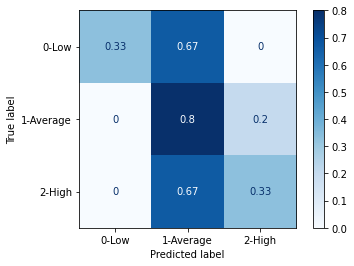

In [56]:
reg_stats_df = evaluate_multiclass_regressor(model1, X_train, y_train, X_test, y_test, stats_df=reg_stats_df,
                             name='Logistic Regression, 10-fold cv x3')
reg_stats_df

### Meta-Classifier - One Vs Rest

In [49]:
model2 = OneVsRestClassifier(model1).fit(X_train, y_train)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.67      0.80         3
   1-Average       0.57      0.80      0.67         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.64        11
   macro avg       0.69      0.60      0.62        11
weighted avg       0.67      0.64      0.63        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,"Logistic Regression, 10-fold cv x3",0.454545,0.545455,0.741667,0.505128
1,OVR Logistic Regression,0.363636,0.636364,0.716667,0.622222


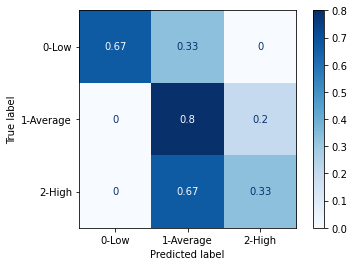

In [57]:
reg_stats_df = evaluate_multiclass_regressor(model2, X_train, y_train, X_test, y_test, name='OVR Logistic Regression',
                             stats_df=reg_stats_df)
reg_stats_df

## K-Nearest Neighbors

### Multiclass Classifier

In [63]:
best_k = 0
best_score = 0.0
for k in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, np.asarray(y_train).reshape(len(y_train), ))
    preds = knn.predict(X_test)
    acc = accuracy_score(y_test, preds, )
    if acc > best_score:
        best_k = k
        best_score = acc

In [64]:
print(f'Best K: {best_k}')
print(f'Accuracy Score: {best_score}')

Best K: 1
Accuracy Score: 0.8181818181818182


In [65]:
model3 = KNeighborsClassifier(n_neighbors=1, n_jobs=3)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.67      0.80         3
   1-Average       0.71      1.00      0.83         5
      2-High       1.00      0.67      0.80         3

    accuracy                           0.82        11
   macro avg       0.90      0.78      0.81        11
weighted avg       0.87      0.82      0.82        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,"Logistic Regression, 10-fold cv x3",0.454545,0.545455,0.741667,0.505128
1,OVR Logistic Regression,0.363636,0.636364,0.716667,0.622222
2,KNN 3 jobs,0.189394,0.727273,0.775000,0.731313
3,OVR KNN 3 jobs,0.189394,0.727273,0.775000,0.731313
4,"KNN k=1, 3 jobs",0.181818,0.818182,0.833333,0.811111


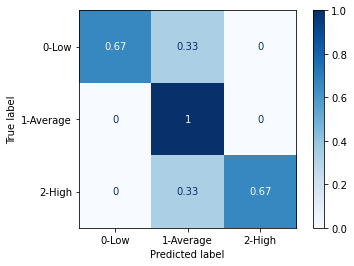

In [66]:
reg_stats_df = evaluate_multiclass_regressor(model3, X_train, y_train, X_test, y_test, 
                                             name='KNN k=1, 3 jobs', stats_df=reg_stats_df)
reg_stats_df

## Decision Tree

In [70]:
model4 = DecisionTreeClassifier(random_state=rs)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.50      0.80      0.62         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.67      0.49      0.51        11
weighted avg       0.64      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,"Logistic Regression, 10-fold cv x3",0.454545,0.545455,0.741667,0.505128
1,OVR Logistic Regression,0.363636,0.636364,0.716667,0.622222
2,KNN 3 jobs,0.189394,0.727273,0.775000,0.731313
3,OVR KNN 3 jobs,0.189394,0.727273,0.775000,0.731313
4,"KNN k=1, 3 jobs",0.181818,0.818182,0.833333,0.811111
5,OVR KNN 3 jobs,0.181818,0.818182,0.833333,0.811111
6,Decision Tree default params,0.454545,0.545455,0.612500,0.505128


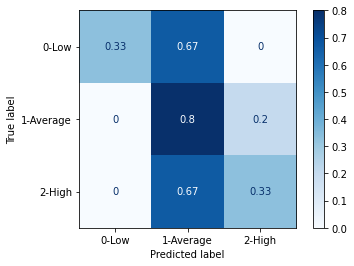

In [71]:
reg_stats_df = evaluate_multiclass_regressor(model4, X_train, y_train, X_test, y_test, stats_df=reg_stats_df,
                                            name='Decision Tree default params')
reg_stats_df

In [81]:
# helpful to see how many features the model is actually using 
# to see if smaller max_feature param might help performance
dt_feat_importances = pd.DataFrame(model4.feature_importances_, index=X_train.columns)\
                                .sort_values(0, ascending=False).reset_index()
dt_feat_importances[dt_feat_importances[0]>0]

,index,0
0,Preventable hospital stays raw value,0.340278
1,Homeownership raw value,0.228626
2,Ratio of population to primary care physicians.,0.148624
3,housing units count,0.073160
4,Percent Native Hawaiian Pacific Islander,0.057483
5,% Rural raw value,0.051020
6,Percent Black,0.034483
7,Drinking water violations raw value,0.034392
8,AREA_SQMI,0.031935


In [82]:
# create a dictionary with the values for each parameter in the decision tree to optimize
dt_param_grid = {'criterion': ['entropy', 'gini'],
                'max_depth': [None, 5, 10, 15],
                'min_samples_leaf': [1, 2],
                'max_features': [3, 5, 8, 10]}

In [84]:
dt_gridsearch = GridSearchCV(model4, dt_param_grid, cv=3, return_train_score=True)

In [86]:
dt_gridsearch.fit(X_train, y_train).best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 2}

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       0.33      0.33      0.33         3
   1-Average       0.57      0.80      0.67         5
      2-High       1.00      0.33      0.50         3

    accuracy                           0.55        11
   macro avg       0.63      0.49      0.50        11
weighted avg       0.62      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,"Logistic Regression, 10-fold cv x3",0.454545,0.545455,0.741667,0.505128
1,OVR Logistic Regression,0.363636,0.636364,0.716667,0.622222
2,KNN 3 jobs,0.189394,0.727273,0.775000,0.731313
3,OVR KNN 3 jobs,0.189394,0.727273,0.775000,0.731313
4,"KNN k=1, 3 jobs",0.181818,0.818182,0.833333,0.811111
5,OVR KNN 3 jobs,0.181818,0.818182,0.833333,0.811111
6,Decision Tree default params,0.454545,0.545455,0.612500,0.505128
7,Grid Search,0.430736,0.545455,0.600000,0.500000


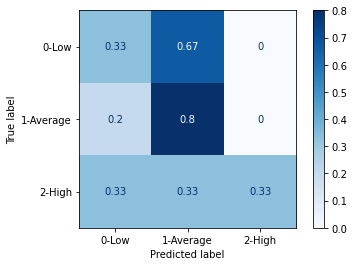

In [87]:
reg_stats_df = evaluate_multiclass_regressor(dt_gridsearch, X_train, y_train, X_test, y_test,
                                       name='Grid Search', stats_df=reg_stats_df)
reg_stats_df

## AdaBoost Classifier

In [88]:
model5 = AdaBoostClassifier(random_state=rs)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       0.50      1.00      0.67         3
   1-Average       0.33      0.20      0.25         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.45        11
   macro avg       0.44      0.51      0.44        11
weighted avg       0.42      0.45      0.40        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,"Logistic Regression, 10-fold cv x3",0.454545,0.545455,0.741667,0.505128
1,OVR Logistic Regression,0.363636,0.636364,0.716667,0.622222
2,KNN 3 jobs,0.189394,0.727273,0.775000,0.731313
3,OVR KNN 3 jobs,0.189394,0.727273,0.775000,0.731313
4,"KNN k=1, 3 jobs",0.181818,0.818182,0.833333,0.811111
5,OVR KNN 3 jobs,0.181818,0.818182,0.833333,0.811111
6,Decision Tree default params,0.454545,0.545455,0.612500,0.505128
7,Grid Search,0.430736,0.545455,0.600000,0.500000
8,Adaboost default params,0.247835,0.454545,0.712500,0.438889


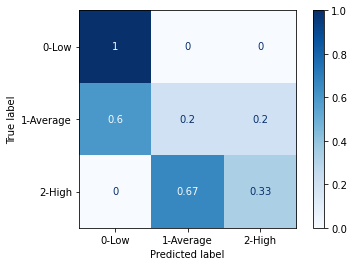

In [89]:
reg_stats_df = evaluate_multiclass_regressor(model5, X_train, y_train, X_test, y_test,
                                            stats_df=reg_stats_df, name='Adaboost default params')
reg_stats_df

## Support Vector Machine

In [105]:
model6 = SVC(kernel='linear', probability=True, random_state=rs)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.50      0.80      0.62         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.67      0.49      0.51        11
weighted avg       0.64      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,"Logistic Regression, 10-fold cv x3",0.454545,0.545455,0.741667,0.505128
1,OVR Logistic Regression,0.363636,0.636364,0.716667,0.622222
2,KNN 3 jobs,0.189394,0.727273,0.775000,0.731313
3,OVR KNN 3 jobs,0.189394,0.727273,0.775000,0.731313
4,"KNN k=1, 3 jobs",0.181818,0.818182,0.833333,0.811111
5,OVR KNN 3 jobs,0.181818,0.818182,0.833333,0.811111
6,Decision Tree default params,0.454545,0.545455,0.612500,0.505128
7,Grid Search,0.430736,0.545455,0.600000,0.500000
8,Adaboost default params,0.247835,0.454545,0.712500,0.438889
9,SVM,0.272727,0.727273,0.841667,0.689744


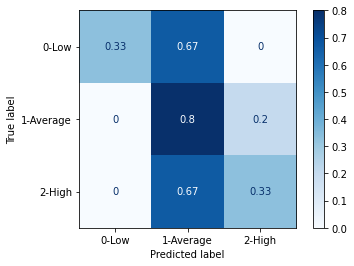

In [106]:
reg_stats_df = evaluate_multiclass_regressor(model6, X_train, y_train, X_test, y_test, 
                                             stats_df=reg_stats_df, name='SVM')
reg_stats_df

### Interpret Coefficients

In [110]:
# save coefficients as a dataframe
svc_coefs = pd.DataFrame(model6.fit(X_train, y_train).coef_, columns=X_train.columns).T
svc_coefs.rename(columns={0: 'Low Impact coefficient', 
                          1: 'Avg Impact coefficient', 
                          2: 'High Impact coefficient'}, inplace=True)
svc_coefs

,Low Impact coefficient,Avg Impact coefficient,High Impact coefficient
CVAC level of concern for vaccination rollout,0.047834,0.072161,0.140827
Percent Hispanic,-0.187786,-0.155177,0.265132
Percent American Indian Alaska Native,0.116065,-0.133929,-0.405347
Percent Asian,0.122731,0.168259,-0.279435
Percent Black,-0.108106,-0.035456,0.014764
Percent Native Hawaiian Pacific Islander,0.085464,0.184940,0.014649
Percent White,0.068574,0.052384,-0.004332
% Population Hesitant or Strongly Hesitant Towards COVID-19 Vaccine,-0.137965,0.053776,0.075788
AREA_SQMI,0.065000,0.152134,0.213540
population,-0.126206,-0.002126,0.116929


In [114]:
# add a column to summarize the relationship, used to color-code a graph
def relationship(x):
    y=None
    if x>0:
        y='positive'
    elif x<0:
        y='negative'
    else:
        y='no relationship'
    return y

In [115]:
svc_coefs['0-Low relationship'] = svc_coefs['Low Impact coefficient'].map(lambda x: relationship(x))
svc_coefs['1-Average relationship'] = svc_coefs['Avg Impact coefficient'].map(lambda x: relationship(x))
svc_coefs['2-High relationship'] = svc_coefs['High Impact coefficient'].map(lambda x: relationship(x))

,Low Impact coefficient,Avg Impact coefficient,High Impact coefficient,0-Low relationship
CVAC level of concern for vaccination rollout,0.047834,0.072161,0.140827,positive
Percent Hispanic,-0.187786,-0.155177,0.265132,negative
Percent American Indian Alaska Native,0.116065,-0.133929,-0.405347,positive
Percent Asian,0.122731,0.168259,-0.279435,positive
Percent Black,-0.108106,-0.035456,0.014764,negative
Percent Native Hawaiian Pacific Islander,0.085464,0.184940,0.014649,positive
Percent White,0.068574,0.052384,-0.004332,positive
% Population Hesitant or Strongly Hesitant Towards COVID-19 Vaccine,-0.137965,0.053776,0.075788,negative
AREA_SQMI,0.065000,0.152134,0.213540,positive
population,-0.126206,-0.002126,0.116929,negative


In [143]:
high_svc_coefs = svc_coefs[['High Impact coefficient', 
                            '2-High relationship']].iloc[svc_coefs['High Impact coefficient'].abs().argsort()]
high_svc_top15 = high_svc_coefs[-15:]

In [138]:
def plot_coefs(coefs_df, coef_col, relationship_col, legend_loc='lower right', title=None):
    # Plot coefficients used in the best-performing model (SVC) in order of absolute value 

    # Shoutout to Shane Lynn for introducing me to Patches 
    # Source: https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/
    coefs_df = coefs_df.iloc[coefs_df[coef_col].abs().argsort()]

    colors = {'positive':'cornflowerblue', 'negative':'rebeccapurple'}
    from matplotlib.patches import Patch

    plt.style.use('seaborn')
    plt.figure(figsize=(6,7), facecolor='white')
    
    plt.barh(y=coefs_df.index, width=coefs_df[coef_col], color=coefs_df[relationship_col].replace(colors))
    
    plt.axvline(x=0, color='black')
    plt.xlabel('Coefficient', fontfamily='tahoma', fontsize=12)
    plt.xticks(fontsize=11, fontfamily='tahoma')
    
    plt.ylabel('Feature', fontfamily='tahoma', fontsize=12)
    plt.yticks(fontsize=11, fontfamily='tahoma')
    
    plt.title(title, fontdict = {'family': 'tahoma', 'size':16})
    
    plt.legend(
        [Patch(facecolor=colors['positive']),
         Patch(facecolor=colors['negative'])], 
        ['positive', 'negative'],
        loc=legend_loc, frameon=True, facecolor='white', title='Relationship with Target',
        prop={'family': 'tahoma', 'size': 11})
    
    plt.savefig(f'./images/{title}.jpg', bbox_inches='tight', pad_inches=1.0)
    plt.show();

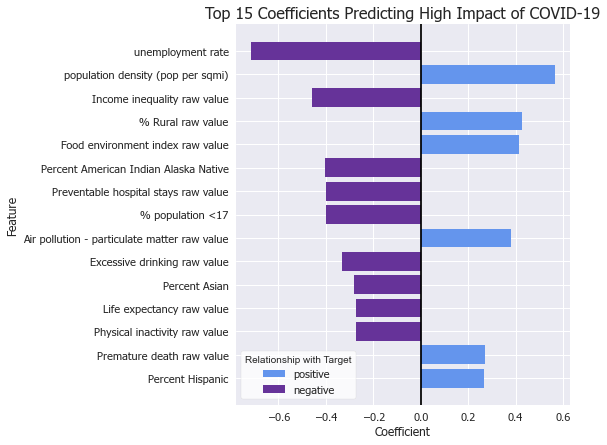

In [144]:
plot_coefs(high_svc_top15, 'High Impact coefficient', '2-High relationship', legend_loc='lower left',
           title='Top 15 Coefficients Predicting High Impact of COVID-19')

In [145]:
low_svc = svc_coefs[['Low Impact coefficient', '0-Low relationship']]
low_svc = low_svc.iloc[low_svc['Low Impact coefficient'].abs().argsort()]
low_svc_top15 = low_svc[-15:]

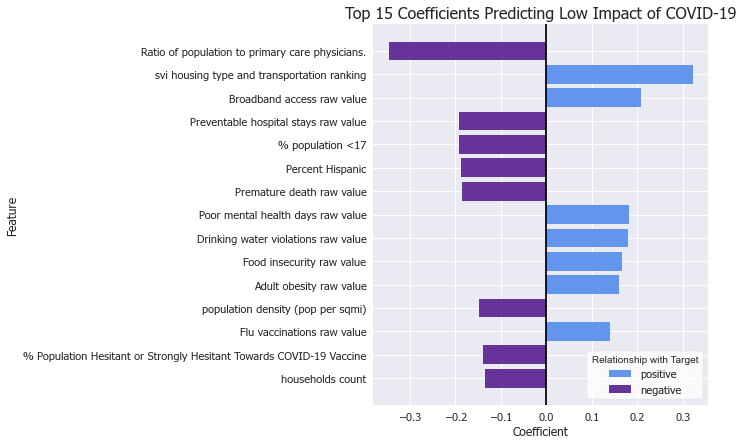

In [146]:
plot_coefs(low_svc_top15, 'Low Impact coefficient', '0-Low relationship',
          title='Top 15 Coefficients Predicting Low Impact of COVID-19')


# Future Enhancements

- Analyze at the county level with updated county-level case and death counts
- Incorporate ICU/hospital capacity in impact calculation

# Appendix

### Binarize target preprocessing steps

1. Binarize target
1. Train-test split
1. Normalize
1. Balance classes in training set

In [20]:
#binarize target
y_bin = sklearn.preprocessing.label_binarize(y, classes=[0,1,2])
#save n_classes as variable
n_classes = y_bin.shape[1]
print(n_classes)
y

3


State
HAWAII                  0
VERMONT                 0
ALASKA                  0
MAINE                   0
OREGON                  0
UTAH                    0
WASHINGTON              0
NEW HAMPSHIRE           0
COLORADO                1
IDAHO                   1
WYOMING                 1
NEBRASKA                1
NORTH CAROLINA          1
VIRGINIA                1
MINNESOTA               1
WISCONSIN               1
MONTANA                 1
WEST VIRGINIA           1
CALIFORNIA              1
KENTUCKY                1
MISSOURI                1
MARYLAND                1
DISTRICT OF COLUMBIA    1
OHIO                    1
DELAWARE                1
KANSAS                  1
FLORIDA                 1
TENNESSEE               1
OKLAHOMA                1
TEXAS                   1
NEVADA                  1
IOWA                    1
ARKANSAS                1
SOUTH CAROLINA          1
ILLINOIS                1
GEORGIA                 1
NORTH DAKOTA            1
INDIANA                 1
NEW ME

In [21]:
#re-do train-test split with binarized target
X2_train , X2_test, y2_train, y2_test = train_test_split(X, y_bin, test_size=0.2, random_state=rs)

In [22]:
#re-scale
X2_train_scaled = pd.DataFrame(scaler.fit_transform(X2_train), columns=X2_train.columns)
X2_test_scaled = pd.DataFrame(scaler.transform(X2_test), columns=X2_test.columns)

In [23]:
#re-balance
smote = SMOTE(sampling_strategy='all', random_state=rs, n_jobs=5, k_neighbors=3)
X2_train_bal, y2_train_bal = smote.fit_resample(X2_train_scaled, y2_train)

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [24]:
#validate class balance
sum_low = 0
sum_avg = 0
sum_high = 0
for e in range(len(y2_train_bal)):
    sum_low += y2_train_bal[e][0]
    sum_avg += y2_train_bal[e][1]
    sum_high += y2_train_bal[e][2]
print(sum_low, sum_avg, sum_high)

28 28 28


In [25]:
#reset variables
X2_train = X2_train_bal
y2_train = y2_train_bal
X2_test = X2_test_scaled
y2_test = y_test

In [29]:
len(y2_test.unique())

3

### Functions - Plot ROC curve and evaluate models with binarized target

In [30]:
def plot_roc_metaclassifier(fit_model, X_test, y_test):
    #save n_classes for ease
    n_classes = len(y_test.unique())
    
    y_score = fit_model.decision_function(X_test)

    #initialize dictionaries to save metrics
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    #calculate fpr, tpr, and roc_auc for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #calculate and save the micro average AUC for all classes
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    #calculate and save macro average fpr, tpr, and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    fpr['macro'] = all_fpr
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    #plot figure with averages and class-specific ROC curves
    sns.set_style('dark')
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Receiver Operating Characteristic (ROC) Curves')
    fig.set_figwidth(12)
    fig.set_figheight(6)
    #ax1 - averages
    ax1.set_title('Micro and Macro Averages')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot([0, 1], [0, 1], color='darkslategray', ls='--')
    ax1.plot(fpr["micro"], tpr["micro"], color='deeppink',
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
    ax1.plot(fpr["macro"], tpr["macro"], color='teal',
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))
    ax1.legend(loc='lower right')
    #ax2 = class curves
    ax2.set_title('ROC Curves by Class')
    ax2.plot([0, 1], [0, 1], color='darkslategray', ls='--')
    from itertools import cycle
    colors = cycle(['darkslateblue', 'gold', 'brown'])
    for i, color in zip(range(n_classes), colors):
        ax2.plot(fpr[i], tpr[i], color=color, 
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    ax2.legend(loc='lower right')
    ax2.set_xlabel('False Positive Rate')

    fig.tight_layout()
    fig.show()
    
    return roc_auc

In [19]:
def evaluate_metaclassifier(model, X_train, y_train, X_test, y_test,
                              stats_df=None, name=None, track=True):
    #fit model on training set
    model.fit(X_train, y_train)
    
    #generate class preditions
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)
    
    #calculate accuracy
    test_acc = accuracy_score(y_test, y_test_preds, normalize=True, )
    train_acc = accuracy_score(y_train, y_train_preds, normalize=True)
    
    #check for overfitting
    overfit = train_acc - test_acc
    
    print('----CLASSIFICATION REPORT----')
    print(classification_report(y_test, y_test_preds))
    
    print('----CONFUSION MATRIX----')
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', normalize='true',
                               display_labels=['0-Low', '1-Average', '2-High'])
    
    print('----ROC CURVE----')
    roc = plot_roc_multiclass(model, X_test, y_test)
    roc
    
    #instantiate df if not passed
    if stats_df is None:
        stats_df = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Overfit Check', 
                                         'Macro-Averaged AUC',
                                         '0-Low AUC', '1-Average AUC', '2-High AUC'])
    #collect metrics in a dictionary    
    stats_dict = {}
    stats_dict['Model Name'] = name
    stats_dict['Accuracy'] = test_acc
    stats_dict['Overfit Check'] = overfit
    stats_dict['Macro-Averaged AUC'] = roc['macro']
    stats_dict['0-Low AUC'] = roc[0]
    stats_dict['1-Average AUC'] = roc[1]
    stats_dict['2-High AUC'] = roc[2]
    
    #if set to track results of this model for aggregation, append dict to stats_df
    if track:
        stats_df = stats_df.append(pd.Series(stats_dict), ignore_index=True)
        print('----SUMMARY----')
        return stats_df